In [1]:
import torch.optim as optim
from utils import *
from model import *
import config
from train import *
from scipy.stats import truncnorm
import torch


c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load weight

In [2]:
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)
critic = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# initialize optimizers and scalers for FP16 training
opt_gen = optim.Adam(gen.parameters(), lr=config.LEARNING_RATE, betas=(0.0, 0.99))

In [3]:
load_checkpoint('../../weightCelebA//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCeleba', n = 200)
load_checkpoint('../../weightCiFAR//generator.pth', gen, opt_gen, config.LEARNING_RATE)
generate_examples(gen, 3, root_path= 'fakeCIFAR', n = 200)

=> Loading checkpoint
=> Loading checkpoint


In [4]:
import cv2
# Load image in LAB format
lab_img = cv2.imread('../fakeCeleba/saved_examples/img_1.png', cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)

# Convert LAB image to RGB
rgb_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
print(type(rgb_img))
# plt.imshow(rgb_img)

<class 'numpy.ndarray'>


In [5]:
steps = [0,1,2,3,4]
alpha = 1

In [6]:
# Generate 1 anh duy nhat 
with torch.no_grad():
    generated_images = []
    noise = torch.tensor(truncnorm.rvs(-0.7, 0.7, size=(1, config.Z_DIM, 1, 1)),
                            device=config.DEVICE, dtype=torch.float32)
    img = gen(noise, alpha, steps[3])
    print(img.shape)
    generated_images.append(img)
    generated_images = torch.cat(generated_images, dim = 0)
    print(generated_images.shape)

torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])


In [7]:
# Load CIFAR (real data)    
real_loader, datasets = get_loader_CIFAR(4 * 2 ** steps[3])
real_C, labels = next(iter(real_loader))

Files already downloaded and verified


In [8]:
# Load CelebA (real data)    
real_loader, datasets = get_loader(4 * 2 ** steps[3], r"../../Celeba_dataset/img_align_celeba")
real_Ce, labels = next(iter(real_loader))

In [9]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCeleba")
fake_CE, labels = next(iter(fake_loader))

In [10]:
from train import *
# Load generated images CelebA (fake data)
fake_loader, datasets = get_loader(4 * 2 ** steps[3],r"../fakeCIFAR")
fake_C, labels = next(iter(fake_loader))

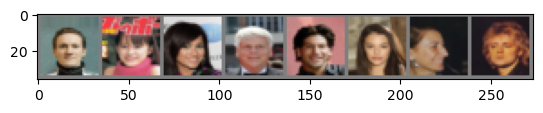

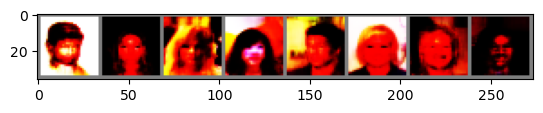

In [11]:
imshow(torchvision.utils.make_grid(real_Ce[:8]))
imshow(torchvision.utils.make_grid(fake_CE[:8]))

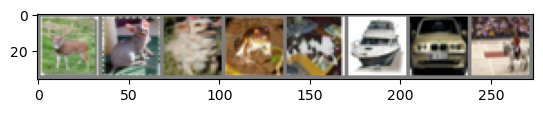

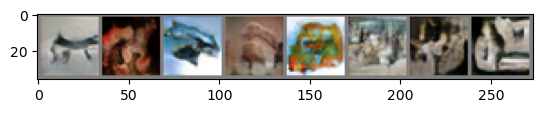

In [12]:
imshow(torchvision.utils.make_grid(real_C[:8]))
imshow(torchvision.utils.make_grid(fake_C[:8]))

In [13]:
print("Calculating Inception Score for CelebA dataset: ")
means_Ce, std_Ce  = inception_score(real_Ce, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake, std_fake = inception_score(fake_CE, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake, means_fake)

Calculating Inception Score for CelebA dataset: 


c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\quock\anaconda3\envs\QuocKhanh\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
d:\LastTerm\Progressive_Growing_of_GAN\ProgressiveGAN\utils.py:123: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


0.1760319669481397 1.3762081467339935
0.1495766022773259 1.503369192435017


In [14]:
print("Calculating Inception Score for CelebA dataset: ")
fid_score(means_Ce, means_fake, std_Ce, std_fake)

Calculating Inception Score for CelebA dataset: 


2.0392295497527146

In [15]:
print("Calculating Inception Score for CIFAR10 dataset: ")
means_C, std_C  = inception_score(real_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_Ce, means_Ce)
means_fake, std_fake  = inception_score(fake_C, cuda=False, batch_size=10, resize=True, splits= 8)
print(std_fake, means_fake)

Calculating Inception Score for CIFAR10 dataset: 
0.1760319669481397 1.3762081467339935
0.15445041982596558 1.4340713883021325


In [16]:
fid_score(means_C, means_fake, std_C, std_fake)

2.1004622584257504